# Preparation

In [0]:
#Import TF functions
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
#Import other function
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#Mount GDrive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
#Set general path, training folder, validation folder
PATH = "/gdrive/My Drive/bangkit_dataset/data"
train_dir = PATH+'/train/'
validation_dir = PATH+'/validation/'

In [0]:
#Set path for each class
train_0_dir = train_dir + '0'
train_1_dir = train_dir + '1'
train_2_dir = train_dir + '2'
train_3_dir = train_dir + '3'
train_4_dir = train_dir + '4'

validation_0_dir = validation_dir + '0'
validation_1_dir = validation_dir + '1'
validation_2_dir = validation_dir + '2'
validation_3_dir = validation_dir + '3'
validation_4_dir = validation_dir + '4'

In [0]:
#Get the number of files in each folder
num_0_tr = len(os.listdir(train_0_dir))
num_1_tr = len(os.listdir(train_1_dir))
num_2_tr = len(os.listdir(train_2_dir))
num_3_tr = len(os.listdir(train_3_dir))
num_4_tr = len(os.listdir(train_4_dir))

num_0_val = len(os.listdir(validation_0_dir))
num_1_val = len(os.listdir(validation_1_dir))
num_2_val = len(os.listdir(validation_2_dir))
num_3_val = len(os.listdir(validation_3_dir))
num_4_val = len(os.listdir(validation_4_dir))

In [8]:
#Get the number of data in each class
print(num_0_tr + num_0_val)
print(num_1_tr + num_1_val)
print(num_2_tr + num_2_val)
print(num_3_tr + num_3_val)
print(num_4_tr + num_4_val)

1805
370
999
193
295


In [9]:
#get number of total training and validation images
total_train = num_0_tr + num_1_tr + num_2_tr + num_3_tr + num_4_tr
total_val = num_0_val + num_1_val + num_2_val + num_3_val + num_4_val 
print("Total training images:", total_train)
print("Total validation images:", total_val)

Total training images: 2566
Total validation images: 1096


# Augment Images

Found 2371 images belonging to 5 classes.
Found 996 images belonging to 5 classes.


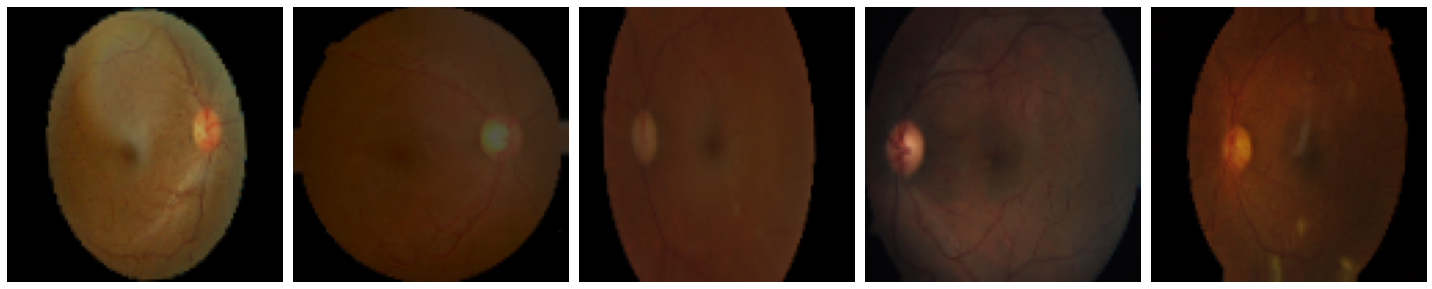

In [10]:
batch_size = 64
epochs = 20
IMG_HEIGHT = 100
IMG_WIDTH = 100

#augment images
train_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=5,
                    horizontal_flip=True,
                    zoom_range=0.1,
                    brightness_range=[0.3,1.0]
                    )
                
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
                    
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                     classes=['0', '1', '2', '3',' 4'])
                                               
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              classes=['0', '1', '2', '3',' 4'])
                                                              
sample_training_images, _ = next(train_data_gen)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])

# Original Model (79.53%)

In [0]:
model = None
history = None

model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', 
            input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    # Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    # Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, padding='same', activation='relu'),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    #Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["acc"])
              
model.summary()

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)
history = history.history

with open('history_aptos_ori', 'wb') as f:
    pickle.dump(history, f)

model.save('aptos_ori.h5')

acc = history['acc']
val_acc = history['val_acc']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

print(model.inputs)
print(model.outputs)


In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Original Model with Adagrad optimizer (78.21%)

In [11]:
model = None
history = None

model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', 
            input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    # Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    # Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, padding='same', activation='relu'),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    #Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='Adagrad',
              loss='binary_crossentropy',
              metrics=["acc"])
              
model.summary()

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)
history = history.history

with open('history_aptos_ori_adagrad', 'wb') as f:
    pickle.dump(history, f)

model.save('aptos_ori_adagrad.h5')

acc = history['acc']
val_acc = history['val_acc']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

print(model.inputs)
print(model.outputs)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 16)        4624      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 16)        2

Text(0.5, 1.0, 'Training and Validation Loss')

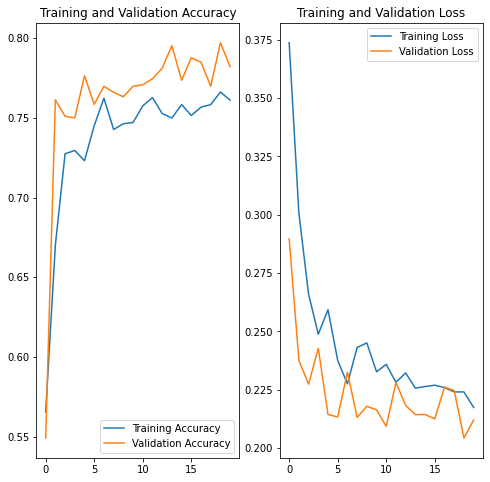

In [12]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Original Model with SGD optimizer (71.23%)

In [13]:
model = None
history = None

model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', 
            input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    # Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    # Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, padding='same', activation='relu'),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    #Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=["acc"])
              
model.summary()

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)
history = history.history

with open('history_aptos_ori_SGD', 'wb') as f:
    pickle.dump(history, f)

model.save('aptos_ori_SGD.h5')

acc = history['acc']
val_acc = history['val_acc']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

print(model.inputs)
print(model.outputs)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 16)        4624      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 25, 25, 16)       

Text(0.5, 1.0, 'Training and Validation Loss')

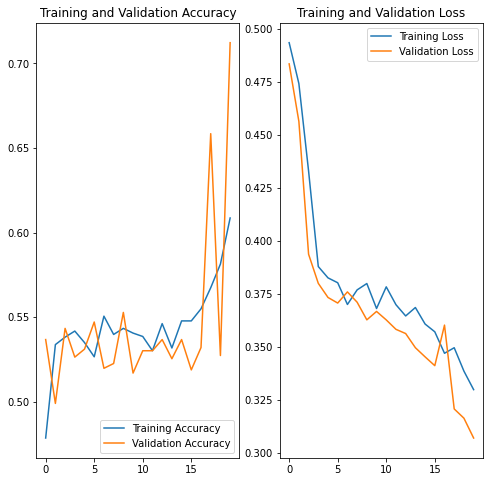

In [14]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Training Model 1 - Original Model with Dense layer at start instead of Conv 2D (80.57%)

In [15]:
model = None
history = None

model = Sequential([
    Dense(64, activation='relu', 
            input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    # Conv2D(64, 3, padding='same', activation='relu', 
    #         input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    #Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, padding='same', activation='relu'),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    #Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["acc"])
              
model.summary()

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)
history = history.history

with open('history_aptos1', 'wb') as f:
    pickle.dump(history, f)

model.save('aptos1.h5')

acc = history['acc']
val_acc = history['val_acc']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

print(model.inputs)
print(model.outputs)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 32)        18464     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 25, 25, 16)        4624      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 16)       

Text(0.5, 1.0, 'Training and Validation Loss')

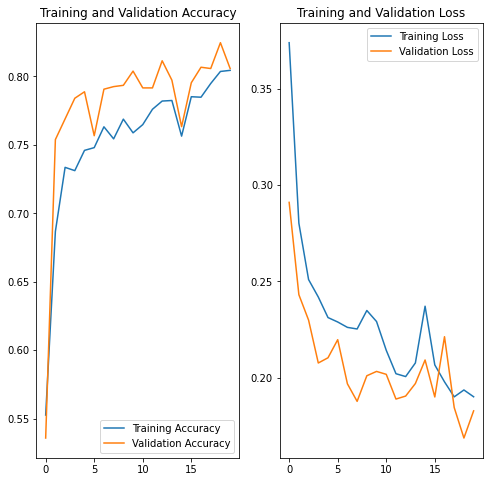

In [16]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Training Model 2 - Original Model with Extra Conv2D(64) + Dropout

In [0]:
model = None
history = None

model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', 
            input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, padding='same', activation='relu'),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    #Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["acc"])
              
model.summary()

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)
history = history.history

with open('history_aptos2', 'wb') as f:
    pickle.dump(history, f)

model.save('aptos2.h5')

acc = history['acc']
val_acc = history['val_acc']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

print(model.inputs)
print(model.outputs)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Training Model 3 (Model 2 Without Dropout) (77.83%)

In [0]:
model = None
history = None

model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', 
            input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    # Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, padding='same', activation='relu'),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    #Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["acc"])
              
model.summary()

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)
history = history.history

with open('history_aptos3', 'wb') as f:
    pickle.dump(history, f)

model.save('aptos3.h5')

acc = history['acc']
val_acc = history['val_acc']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

print(model.inputs)
print(model.outputs)


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 50, 50, 32)        18464     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 25, 25, 16)       

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Training Model 4

In [0]:
model = None
history = None

model = Sequential([    
    Conv2D(128, 3, padding='same', activation='relu', 
            input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
   
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    # Dropout(0.2),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, padding='same', activation='relu'),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    #Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["acc"])
              
model.summary()

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)
history = history.history

with open('history_aptos4', 'wb') as f:
    pickle.dump(history, f)

model.save('aptos4.h5')

acc = history['acc']
val_acc = history['val_acc']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

print(model.inputs)
print(model.outputs)


In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Training Model 5 (Model 4 with different filter size)

In [0]:
model = None
history = None

model = Sequential([    
    Conv2D(128, 11, padding='same', activation='relu', 
            input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
   
    MaxPooling2D(),
    Conv2D(64, 7, padding='same', activation='relu'),
    # Dropout(0.2),
    MaxPooling2D(),
    Conv2D(32, 5, padding='same', activation='relu'),
    Conv2D(32, 5, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, padding='same', activation='relu'),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    #Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["acc"])
              
model.summary()

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)
history = history.history

with open('history_aptos5', 'wb') as f:
    pickle.dump(history, f)

model.save('aptos5.h5')

acc = history['acc']
val_acc = history['val_acc']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

print(model.inputs)
print(model.outputs)


In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')